In [1]:
import datetime
import ee
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.preprocessing

from dateutil.relativedelta import relativedelta
from dateutil.relativedelta import relativedelta
from scipy import stats

ee.Initialize()

In [137]:
def init():
    
    '''
    Set the init params:
    1) Area
    2) Satellite 
    3) Years to analyze 
    
    '''
    
    ##### AREA #####
    
    # HUC 4s draining to the CV 
    cv = gp.read_file("../shape/cv_hu6.shp")
    lls = cv.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    
    area = ee.Geometry.Polygon(coords)
        
    ###### SATELLITES ######
    
    # ET 
    modis = ee.ImageCollection('MODIS/006/MOD16A2')
    gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H')
    nldas = ee.ImageCollection("NASA/NLDAS/FORA0125_H002")
    terraclimate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
    gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
    
    # P
    trmm = ee.ImageCollection('TRMM/3B43V7')
    prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81m")
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
    persiann = ee.ImageCollection("NOAA/PERSIANN-CDR")
    
    ##### TIME RANGE #####
    years = [x for x in range(2001, 2016)]
    
    return [[modis,gldas,nldas,terraclimate,gridmet,trmm,prism,chirps,persiann],area,years]
    
def retrieve(satellite):
    
    # ET
    if satellite == ee.ImageCollection('MODIS/006/MOD16A2'):
        var = "ET"
    elif satellite == ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'):
        var = "Evap_tavg"
    elif satellite == ee.ImageCollection('NASA/NLDAS/FORA0125_H002'):
        var = "potential_evaporation"
    elif satellite == ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'):
        var = "pet"
    elif satellite == ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'):
        var = "etr"
    
    # Precip
    if satellite == ee.ImageCollection('TRMM/3B42'):
        var = "precipitation"
    if satellite == ee.ImageCollection('TRMM/3B43V7'):
        var = "precipitation"
    if satellite == ee.ImageCollection("OREGONSTATE/PRISM/AN81m"):
        var = "ppt"
    if satellite == ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'):
        var = "precipitation"
    if satellite == ee.ImageCollection("NOAA/PERSIANN-CDR"):
        var = "precipitation"

    return var

In [138]:
def filter_date(product,year):
    '''
    filters the start and end dates, selects appropriate band for a given product and a given start year
    '''
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,1,1)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select(retrieve(product))
    return prod
    
def aggregate_product(product,year):
    
    '''
    calculate the monthly sum of a RS measurement.
    Resolution is set in the if/else block at the beginning
    Set the "res" lower if you exceed the google request
    '''
        
    if product == ee.ImageCollection('MODIS/006/MOD16A2'):
        res = 2500
    elif product == ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'):
        res = 12500
    elif product == ee.ImageCollection('NASA/NLDAS/FORA0125_H002'):
        res = 12500
    elif product == ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'):
        res = 4000
    elif product == ee.ImageCollection('IDAHO_EPSCOR/GRIDMET'):
        res = 4000
        
    elif product == ee.ImageCollection('TRMM/3B42'):
        res = 12500
    elif product == ee.ImageCollection('TRMM/3B43V7'):
        res = 12500
    elif product == ee.ImageCollection("OREGONSTATE/PRISM/AN81m"):
        res = 3200
    elif product == ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'):
        res = 5500
    if product == ee.ImageCollection("NOAA/PERSIANN-CDR"):
        res = 12500
    
    # Filter
    filtered = filter_date(product, year)

    # calculate the monthly sum
    def calc_sum(imageCollection,year):
        mylist = ee.List([])
        months = range(1,13)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).mean();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    monthly = ee.ImageCollection(calc_sum(filtered, year))

    # select the region of interest, res is the cellsize in meters
    monthly = monthly.getRegion(area,res,"epsg:4326").getInfo()

    return monthly 

def df_from_ee_object(ee_image):
    
    '''
    transforms an ee.Image to a pandas dataframe
    '''
    
    df = pd.DataFrame(ee_image, columns = ee_image[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable, month):
    
    '''
    Transforms a pandas dataframe created from df_from_ee_object to a numpy array that can be plotted with imshow(array)
    '''
    
    df = df[df.id == str(month)] 
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # start from lower left corner
    
    return arr

In [139]:
def main(years, product):
    '''
    main routine that wraps the helper functions above for a list of years and a single RS product 
    '''
    finals = []
    for year in years:
        finals.append(aggregate_product(product,year))
    
    dfs = []
    for i in finals:
        dfs.append(df_from_ee_object(i))
    
    months = [int(x) for x in dfs[0].id.unique()]
    
    yearly = []
    for i in dfs:
        result = []
        for m in months:
            monthly = []
            a = array_from_df(i,retrieve(product),m)
            result.append(a)
        yearly.append(result)
        
    yearly_arrays = [np.array(x) for x in yearly]
    timeseries = [np.array(x) for x in yearly_arrays]
    all_data = [item for sublist in timeseries for item in sublist]
    final = np.dstack(all_data)
    final = np.ma.masked_where(final == 0, final)
        
    return final

In [131]:
sats, area, years = init()

In [39]:
modis = main(years, sats[0])

In [40]:
gldas = main(years, sats[1])

In [44]:
nldas = main(years, sats[2])

In [45]:
terraclimate = main(years, sats[3])

In [47]:
gridmet = main(years, sats[4])

In [110]:
# apply scale factors
m = modis * 0.1 # provided by ee
g = gldas * 86400 # gldas is given per second, convert to monthly
n = nldas.copy()
t = terraclimate * 0.1 # provided by ee
i = gridmet.copy()

/Users/aakash/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


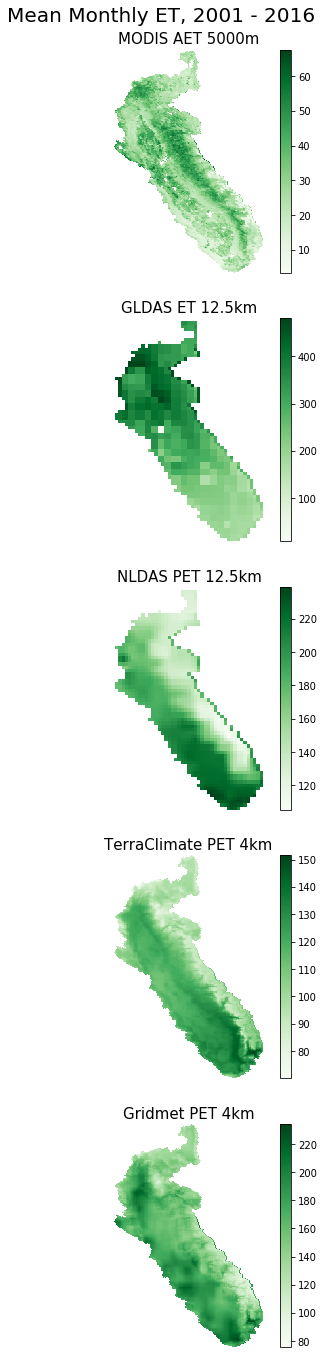

In [115]:
f = plt.figure(figsize=(5,20))

plt.suptitle("Mean Monthly ET, 2001 - 2016", size = 20)

plt.subplot(5,1,1)
plt.imshow(np.nanmean(m, axis = 2),cmap = plt.get_cmap("Greens")) 
plt.colorbar()
plt.title("MODIS AET 5000m", size = 15)
plt.axis('off')

plt.subplot(5,1,2)
plt.imshow(np.mean(g, axis = 2),cmap = plt.get_cmap("Greens"))
plt.title("GLDAS ET 12.5km", size = 15)
plt.colorbar()
plt.axis('off')

plt.subplot(5,1,3)
plt.imshow(np.mean(n, axis = 2),cmap = plt.get_cmap("Greens")) 
plt.colorbar()
plt.title("NLDAS PET 12.5km", size = 15)
plt.axis('off')

plt.subplot(5,1,4)
plt.imshow(np.mean(t, axis = 2),cmap = plt.get_cmap("Greens"))
plt.title("TerraClimate PET 4km", size = 15)
plt.colorbar()
plt.axis('off')

plt.subplot(5,1,5)
plt.imshow(np.mean(i, axis = 2),cmap = plt.get_cmap("Greens"))
plt.title("Gridmet PET 4km", size = 15)
plt.colorbar()
plt.axis('off')

f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [112]:
def get_monthly_sum(array):
    arr = array.copy()
    
    totals = []
    for i in range(0,array.shape[2]):
        total = np.nanmean(array[:,:,i]) * array.shape[0] *array.shape[2]
        totals.append(total)
        
    return np.array(totals)

In [113]:
# Sum monthly
m_s = get_monthly_sum(m)
g_s = get_monthly_sum(g)
n_s = get_monthly_sum(n)
t_s = get_monthly_sum(t)
i_s = get_monthly_sum(i)

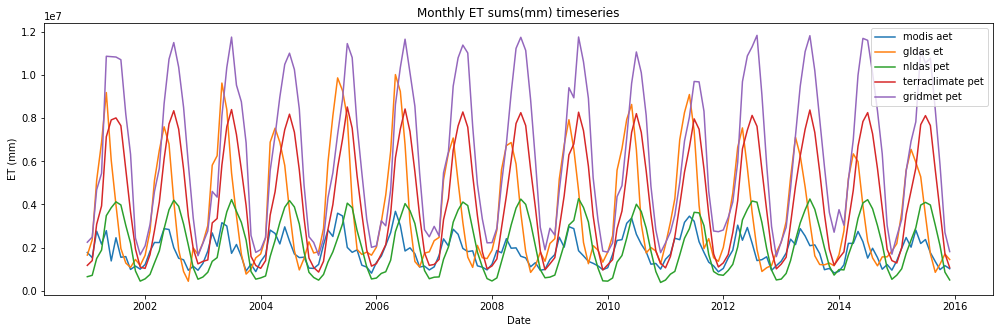

In [114]:
dates = [datetime.date(2001, 1, 1) + relativedelta(months=x) for x in range(0, 180)]

plt.figure(figsize=(17,5))
plt.title("Monthly ET sums(mm) timeseries")
plt.plot(dates,m_s, label = "modis aet")
plt.plot(dates,g_s, label = "gldas et")
plt.plot(dates,n_s, label = "nldas pet")
plt.plot(dates,t_s, label = "terraclimate pet")
plt.plot(dates,i_s, label = "gridmet pet")
plt.ylabel("ET (mm)")
plt.xlabel("Date")
plt.legend()

# plt.savefig("../figs/et_comparison.png")

plt.show()

In [153]:
et_outdf = pd.DataFrame(
    {'modis_aet': m_s,
     'gldas_et': g_s,
     'nldas_pet': n_s,
     'terraclimate_pet': t_s,
     'gridmet_pet': i_s
    })

et_outdf.index = dates
et_outdf.head()

,modis_aet,gldas_et,nldas_pet,terraclimate_pet,gridmet_pet
2001-01-01,1.773670e+06,1.653691e+06,6.516986e+05,1.177349e+06,2.250161e+06
2001-02-01,1.534297e+06,2.365955e+06,7.158773e+05,1.398415e+06,2.490544e+06
2001-03-01,2.761055e+06,5.119058e+06,1.495256e+06,3.083506e+06,4.683356e+06
2001-04-01,2.159400e+06,6.887351e+06,1.886299e+06,3.933848e+06,5.444924e+06
2001-05-01,2.787220e+06,9.190107e+06,3.482862e+06,7.141112e+06,1.087330e+07


In [117]:
et_outdf.to_csv("../data/et_comp.csv")

In [125]:
# precipitation

In [132]:
trmm = main(years, sats[5])

In [133]:
prism = main(years, sats[6])

In [134]:
chirps = main(years, sats[7])

In [140]:
persiann = main(years, sats[8])

In [141]:
# apply scale factors
j = trmm*730.
p = prism.copy()
c = chirps.copy()
s = persiann.copy()

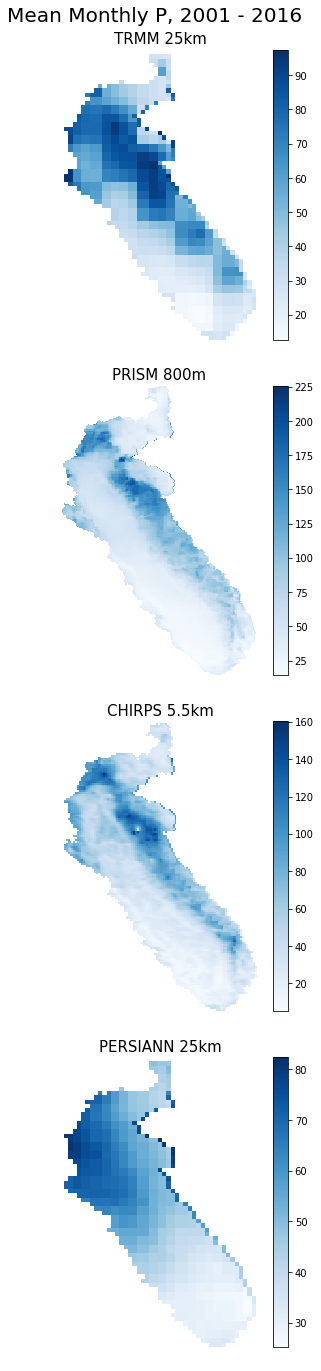

In [142]:
f = plt.figure(figsize=(5,20))

plt.suptitle("Mean Monthly P, 2001 - 2016", size = 20)

plt.subplot(4,1,1)
plt.imshow(np.nanmean(j, axis = 2),cmap = plt.get_cmap("Blues")) 
plt.colorbar()
plt.title("TRMM 25km", size = 15)
plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(np.mean(p, axis = 2),cmap = plt.get_cmap("Blues"))
plt.colorbar()
plt.title("PRISM 800m", size = 15)
plt.axis('off')

plt.subplot(4,1,3)
plt.imshow(np.mean(c, axis = 2),cmap = plt.get_cmap("Blues")) 
plt.colorbar()
plt.title("CHIRPS 5.5km", size = 15)
plt.axis('off')

plt.subplot(4,1,4)
plt.imshow(np.mean(s, axis = 2),cmap = plt.get_cmap("Blues"))
plt.title("PERSIANN 25km", size = 15)
plt.colorbar()
plt.axis('off')

f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [143]:
# Sum monthly

j_s = get_monthly_sum(j)
p_s = get_monthly_sum(p)
c_s = get_monthly_sum(c)
s_s = get_monthly_sum(s)

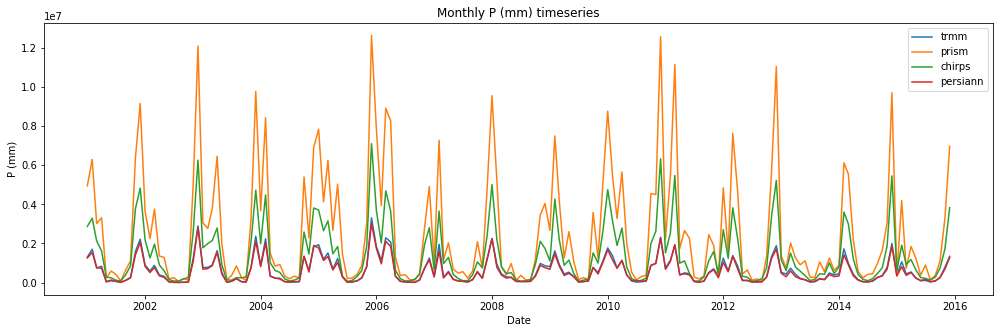

In [144]:
dates = [datetime.date(2001, 1, 1) + relativedelta(months=x) for x in range(0, 180)]

plt.figure(figsize=(17,5))
plt.title("Monthly P (mm) timeseries")
plt.plot(dates,j_s, label = "trmm")
plt.plot(dates,p_s, label = "prism")
plt.plot(dates,c_s, label = "chirps")
plt.plot(dates,s_s, label = "persiann")
plt.ylabel("P (mm)")
plt.xlabel("Date")
plt.legend()

# plt.savefig("../figs/et_comparison.png")

plt.show()

In [145]:
p_outdf = pd.DataFrame(
    {'trmm_p': j_s,
     'prism_p': p_s,
     'chirps_p': c_s,
     'persiann_p': s_s
    })

p_outdf.index = dates
p_outdf.head()

,trmm_p,prism_p,chirps_p,persiann_p
2001-01-01,1.298984e+06,4.943601e+06,2.870981e+06,1.256889e+06
2001-02-01,1.701509e+06,6.301808e+06,3.290672e+06,1.536677e+06
2001-03-01,7.353505e+05,3.016583e+06,2.122979e+06,7.710315e+05
2001-04-01,8.320125e+05,3.311150e+06,1.620348e+06,7.208435e+05
2001-05-01,3.331329e+04,2.375694e+05,2.811884e+05,4.465109e+04


In [146]:
p_outdf.to_csv("../data/p_comp.csv")

In [ ]:
# BALANCE

In [149]:
# Read in the storage CSVs from the data folder

# find files
data_dir = "../data"
ds_file = [os.path.join(data_dir,x) for x in os.listdir("../data") if "storage" in x][0]
ds = pd.read_csv(ds_file, sep='\t', header=0)

q_file = [os.path.join(data_dir,x) for x in os.listdir("../data") if "Qs" in x][0]
q = pd.read_csv(q_file)

In [150]:
ds.set_index(ds['dt'], inplace = True)
q.set_index(q.columns[0], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)

In [151]:
# convert to datetime
ds.index = pd.to_datetime(ds.index)
q.index = pd.to_datetime(q.index)

# Change the ds index to be beginning of the month
ds.index += datetime.timedelta(days = 1)


In [154]:
# Merge the dfs
merged1 = pd.merge(et_outdf,p_outdf, left_index=True, right_index=True)
merged1.head()

,modis_aet,gldas_et,nldas_pet,terraclimate_pet,gridmet_pet,trmm_p,prism_p,chirps_p,persiann_p
2001-01-01,1.773670e+06,1.653691e+06,6.516986e+05,1.177349e+06,2.250161e+06,1.298984e+06,4.943601e+06,2.870981e+06,1.256889e+06
2001-02-01,1.534297e+06,2.365955e+06,7.158773e+05,1.398415e+06,2.490544e+06,1.701509e+06,6.301808e+06,3.290672e+06,1.536677e+06
2001-03-01,2.761055e+06,5.119058e+06,1.495256e+06,3.083506e+06,4.683356e+06,7.353505e+05,3.016583e+06,2.122979e+06,7.710315e+05
2001-04-01,2.159400e+06,6.887351e+06,1.886299e+06,3.933848e+06,5.444924e+06,8.320125e+05,3.311150e+06,1.620348e+06,7.208435e+05
2001-05-01,2.787220e+06,9.190107e+06,3.482862e+06,7.141112e+06,1.087330e+07,3.331329e+04,2.375694e+05,2.811884e+05,4.465109e+04


In [155]:
# Merge the dfs
merged2 = pd.merge(merged1,q, left_index=True, right_index=True)
merged2.head()

,modis_aet,gldas_et,nldas_pet,terraclimate_pet,gridmet_pet,trmm_p,prism_p,chirps_p,persiann_p,discharge_cms
2001-01-01,1.773670e+06,1.653691e+06,6.516986e+05,1.177349e+06,2.250161e+06,1.298984e+06,4.943601e+06,2.870981e+06,1.256889e+06,368.118400
2001-02-01,1.534297e+06,2.365955e+06,7.158773e+05,1.398415e+06,2.490544e+06,1.701509e+06,6.301808e+06,3.290672e+06,1.536677e+06,504.039040
2001-03-01,2.761055e+06,5.119058e+06,1.495256e+06,3.083506e+06,4.683356e+06,7.353505e+05,3.016583e+06,2.122979e+06,7.710315e+05,903.305920
2001-04-01,2.159400e+06,6.887351e+06,1.886299e+06,3.933848e+06,5.444924e+06,8.320125e+05,3.311150e+06,1.620348e+06,7.208435e+05,393.603520
2001-05-01,2.787220e+06,9.190107e+06,3.482862e+06,7.141112e+06,1.087330e+07,3.331329e+04,2.375694e+05,2.811884e+05,4.465109e+04,262.496736


In [156]:
# Set the timezones to none
merged3 = merged2.tz_localize(None).copy()
ds = ds.tz_localize(None).copy()

# Merge again
df = pd.merge(merged3, ds, left_index=True, right_index=True)

# Drop irrelevant columns
df.drop(["region", 'dt'], axis = 1, inplace = True)

In [218]:
# Get the area over which precip and ET were calculated over
a1 = gp.read_file("../shape/1802_4.shp")
a2 = gp.read_file("../shape/1803_4.shp")
a3 = gp.read_file("../shape/1804_4.shp")

sa = a1.AreaSqKm.values + a2.AreaSqKm.values + a3.AreaSqKm.values
study_area = sa * 1e6 # sq km to sq m

# Now convert to the appropriate units
df['q'] = df.discharge_cms * 2.628e+6 # convert cms to cubic m/month
df['p'] = df.prism_p*study_area * 1e-3 # multiply by study area and convert mm to m
df['et'] = df.gridmet_pet*study_area * 1e-3 # multiply by study area and convert mm to m 
df['s_m3'] = df.s * 1.23348e+9 # convert from million acre ft to cubic m 

In [219]:
df['ds'] = df.p - df.et - df.q

In [220]:
np.sum(df.ds) * 1e-9

-102894342.65119709

In [221]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 11

for year in years:

    # Select df for nov and the first year
    ydf1 = df.iloc[df.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = df.iloc[df.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = df.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['s_m3'][-1] - hydro_year_df['s_m3'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()

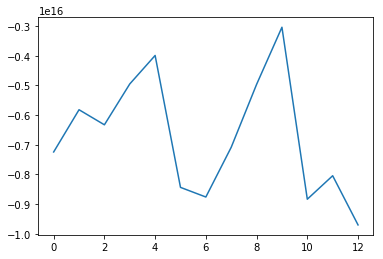

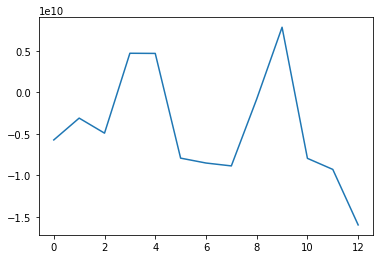

In [222]:
plt.plot(rs_sums.values())
plt.show()

plt.plot(c2v_sums.values())
plt.show()

In [9]:
def calc_spatial_trend(array):

    t = array.copy()

    x_array = np.arange(t.shape[2]) # time dimension

    slopes = []

    for i in range(0, t.shape[0]):
        for j in range(0, t.shape[1]):
            y_array = t[i,j,:]
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_array,y_array)
            slopes.append(slope)
                
    s = np.array(slopes)
    s = s.reshape(t.shape[0],t.shape[1])
    s[s == 0 ] = np.nan
    
    return s

In [10]:
st_1 = calc_spatial_trend(prism)
st_2 = calc_spatial_trend(gridmet)

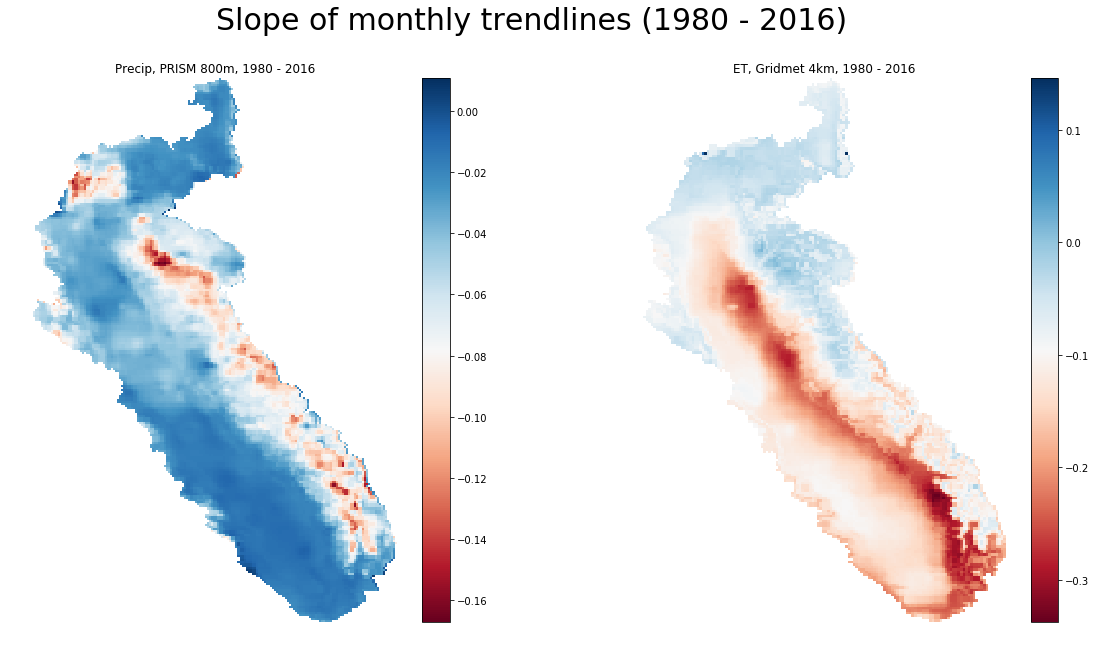

In [11]:
f = plt.figure(figsize=(20,10))

plt.suptitle("Slope of monthly trendlines (1980 - 2016)", size = 30)

plt.subplot(1,2,1)
plt.imshow(st_1,cmap = plt.get_cmap("RdBu"))
plt.colorbar()
plt.title("Precip, PRISM 800m, 1980 - 2016")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(st_2,cmap = plt.get_cmap("RdBu"))
plt.title("ET, Gridmet 4km, 1980 - 2016")
plt.colorbar()
plt.axis('off')

plt.show()

In [76]:
def get_monthly_sum(array):
    arr = array.copy()
    
    totals = []
    for i in range(0,array.shape[2]):
        total = np.nanmean(array[:,:,i]) * array.shape[0] *array.shape[2]
        totals.append(total)
        
    return np.array(totals)

In [77]:
p_sums = get_monthly_sum(prism)
g_sums = get_monthly_sum(gridmet)

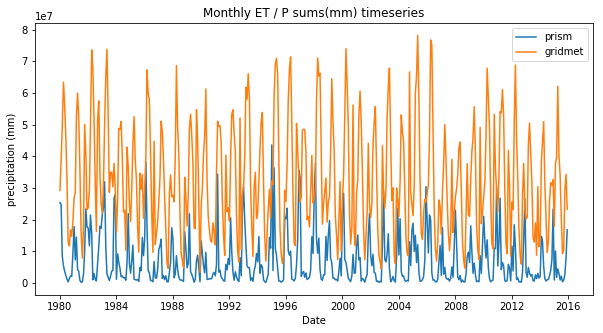

In [80]:
dates = [datetime.date(1980, 1, 1) + relativedelta(months=x) for x in range(0, 432)]

plt.figure(figsize=(10,5))
plt.title("Monthly ET / P sums(mm) timeseries")
plt.plot(dates,p_sums, label = "prism")
plt.plot(dates,g_sums, label = "gridmet")
plt.ylabel("precipitation (mm)")
plt.xlabel("Date")
plt.legend()

# plt.savefig("../figs/monthly_timeseries.png")

plt.show()

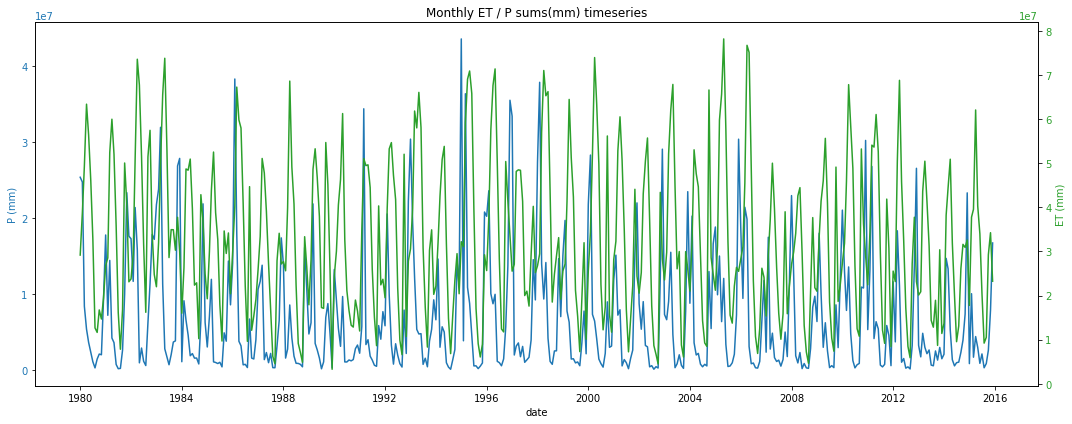

In [81]:
dates = [datetime.date(1980, 1, 1) + relativedelta(months=x) for x in range(0, 432)]

fig, ax1 = plt.subplots(figsize=(15,6))

plt.title("Monthly ET / P sums(mm) timeseries")

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel("P (mm)", color=color)
ax1.plot(dates, p_sums, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('ET (mm)', color=color)  
ax2.plot(dates,g_sums,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

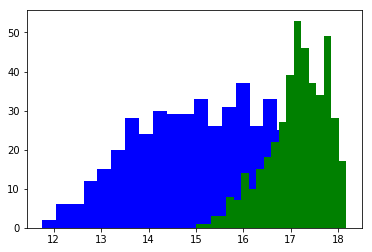

In [82]:
plt.hist(np.log(p_sums), bins = 20, color = "blue")
plt.hist(np.log(g_sums), bins = 20, color = "green")
plt.show()

In [83]:
outdf = pd.DataFrame(
    {'gridmet': g_sums,
     'prism': p_sums,
    })

outdf.index = dates

In [84]:
outdf.head()

,gridmet,prism
1980-01-01,2.917595e+07,2.535676e+07
1980-02-01,3.870969e+07,2.472921e+07
1980-03-01,4.932931e+07,8.405792e+06
1980-04-01,6.336753e+07,5.394146e+06
1980-05-01,5.640832e+07,3.663737e+06


In [85]:
# Read in the storage CSVs from the data folder

# find files
data_dir = "../data"
ds_file = [os.path.join(data_dir,x) for x in os.listdir("../data") if "storage" in x][0]
ds = pd.read_csv(ds_file, sep='\t', header=0)

q_file = [os.path.join(data_dir,x) for x in os.listdir("../data") if "Qs" in x][0]
q = pd.read_csv(q_file)


In [86]:
ds.set_index(ds['dt'], inplace = True)
q.set_index(q.columns[0], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)

In [87]:
# convert to datetime
ds.index = pd.to_datetime(ds.index)
q.index = pd.to_datetime(q.index)

# Change the ds index to be beginning of the month
ds.index += datetime.timedelta(days = 1)


In [88]:
outdf.head(), ds.head(), q.head()

(                 gridmet         prism
 1980-01-01  2.917595e+07  2.535676e+07
 1980-02-01  3.870969e+07  2.472921e+07
 1980-03-01  4.932931e+07  8.405792e+06
 1980-04-01  6.336753e+07  5.394146e+06
 1980-05-01  5.640832e+07  3.663737e+06,
                                              dt            s     region
 dt                                                                     
 1973-11-01 00:00:00+00:00  1973-10-31T00:00:00Z  4575.555111  Entire CV
 1973-12-01 00:00:00+00:00  1973-11-30T00:00:00Z  4578.075790  Entire CV
 1974-01-01 00:00:00+00:00  1973-12-31T00:00:00Z  4581.297108  Entire CV
 1974-02-01 00:00:00+00:00  1974-01-31T00:00:00Z  4585.170011  Entire CV
 1974-03-01 00:00:00+00:00  1974-02-28T00:00:00Z  4588.180232  Entire CV,
             discharge_cms
 Unnamed: 0               
 1980-01-01     1095.86016
 1980-01-02     1197.80064
 1980-01-03     1200.63232
 1980-01-04     1152.49376
 1980-01-05     1067.54336)

In [89]:
# Merge the dfs
merged1 = pd.merge(outdf,q, left_index=True, right_index=True)
merged1.head()

,gridmet,prism,discharge_cms
1980-01-01,2.917595e+07,2.535676e+07,1095.86016
1980-02-01,3.870969e+07,2.472921e+07,1268.59264
1980-03-01,4.932931e+07,8.405792e+06,2030.31456
1980-04-01,6.336753e+07,5.394146e+06,832.51392
1980-05-01,5.640832e+07,3.663737e+06,458.73216


In [90]:
# Set the timezones to none
merged2 = merged1.tz_localize(None).copy()
ds = ds.tz_localize(None).copy()

# Merge again
df = pd.merge(merged2, ds, left_index=True, right_index=True)

# Drop irrelevant columns
df.drop(["region", 'dt'], axis = 1, inplace = True)

In [91]:
df.head()

,gridmet,prism,discharge_cms,s
1980-01-01,2.917595e+07,2.535676e+07,1095.86016,4586.674670
1980-02-01,3.870969e+07,2.472921e+07,1268.59264,4588.686787
1980-03-01,4.932931e+07,8.405792e+06,2030.31456,4590.926975
1980-04-01,6.336753e+07,5.394146e+06,832.51392,4592.742504
1980-05-01,5.640832e+07,3.663737e+06,458.73216,4593.733395


In [92]:
# Get the area over which precip and ET were calculated over
hu4 = gp.read_file("../shape/cv_hu6.shp")
study_area = hu4.AreaSqKm.values
study_area = study_area * 1000000. # sq km to sq m

# Now convert to the appropriate units

df['q'] = df.discharge_cms*2.628e+6 # convert cms to cubic m/month
df['p'] = df.prism*study_area * 1e-3 # multiply by study area and convert mm to m
df['et'] = df.gridmet*study_area * 1e-3 * 0.01 # multiply by study area and convert mm to m, apply ET scaling factor 
df['s_m3'] = df.s * 1.23348e+9 # convert from million acre ft to cubic m 

In [93]:
df.head()

,gridmet,prism,discharge_cms,s,q,p,et,s_m3
1980-01-01,2.917595e+07,2.535676e+07,1095.86016,4586.674670,2.879921e+09,1.077600e+15,1.239906e+13,5.657571e+12
1980-02-01,3.870969e+07,2.472921e+07,1268.59264,4588.686787,3.333861e+09,1.050930e+15,1.645066e+13,5.660053e+12
1980-03-01,4.932931e+07,8.405792e+06,2030.31456,4590.926975,5.335667e+09,3.572254e+14,2.096374e+13,5.662817e+12
1980-04-01,6.336753e+07,5.394146e+06,832.51392,4592.742504,2.187847e+09,2.292379e+14,2.692963e+13,5.665056e+12
1980-05-01,5.640832e+07,3.663737e+06,458.73216,4593.733395,1.205548e+09,1.556998e+14,2.397214e+13,5.666278e+12


In [94]:
df['ds'] = df.p - df.et - df.q

In [95]:
# Compute annual ds sums from ds = P - ET - Q:
years = np.arange(df.index[0].year, df.index[-1].year-1)

rs_sums = {}
c2v_sums = {}

startmonth = 11

for year in years:

    # Select df for nov and the first year
    ydf1 = df.iloc[df.index.year == year]
    mdf1 = ydf1.iloc[ydf1.index.month == startmonth]
    
    # advance a year and select df
    nextyear_df = df.iloc[df.index.year == year+1]
    nextmonth_df = nextyear_df.iloc[nextyear_df.index.month == startmonth-1]
    
    # subset original df based on start and end indices
    hydro_year_df = df.loc[mdf1.index[0] : nextmonth_df.index[0]]
    
    # compute the sums
    c2v_sums[year] = hydro_year_df['s_m3'][-1] - hydro_year_df['s_m3'][0]
    rs_sums[year] = hydro_year_df['ds'].sum()

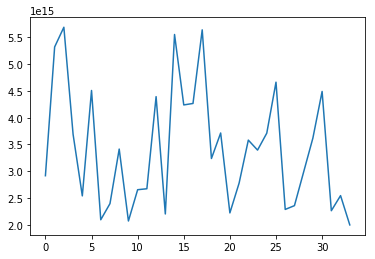

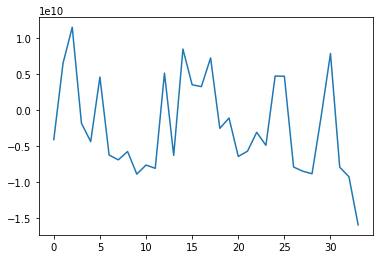

In [96]:
plt.plot(rs_sums.values())
plt.show()

plt.plot(c2v_sums.values())
plt.show()

In [97]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=1),  freq='Y')
ds_df = pd.DataFrame({'ds':list(rs_sums.values()), 'c2vds': list(c2v_sums.values())})

ds_df.head()

,ds,c2vds
0,2.915891e+15,-4.105465e+09
1,5.320640e+15,6.495604e+09
2,5.688843e+15,1.151124e+10
3,3.689158e+15,-1.839631e+09
4,2.539300e+15,-4.376534e+09


In [98]:
mms = sklearn.preprocessing.StandardScaler()

scaled = []

for i in [ds_df['ds'],ds_df['c2vds'],df['s_m3']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


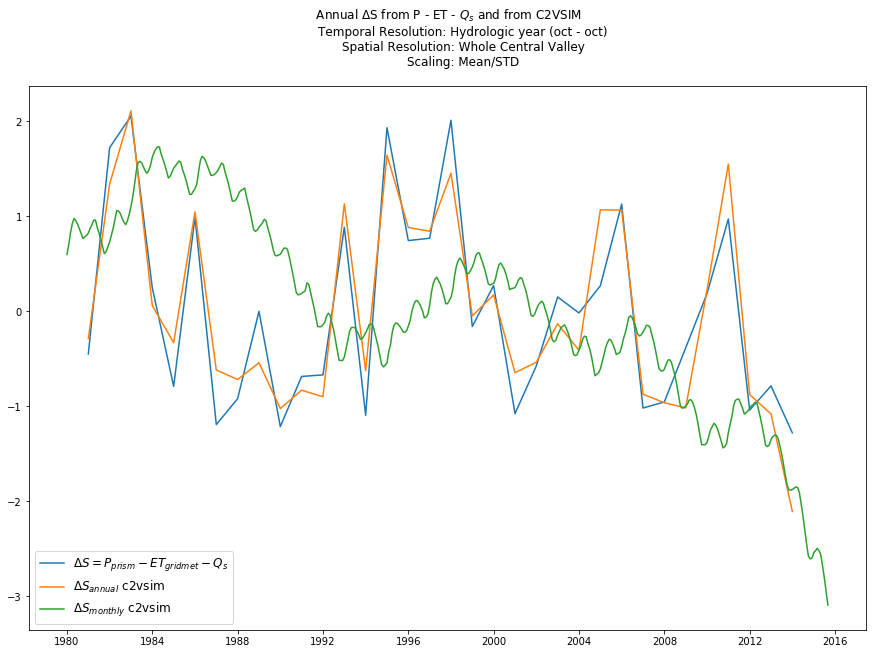

In [99]:
plt.figure(figsize=(15,10))

plt.title(
    """ Annual $\Delta$S from P - ET - $Q_s$ and from C2VSIM
        Temporal Resolution: Hydrologic year (oct - oct)
        Spatial Resolution: Whole Central Valley
        Scaling: Mean/STD
    """)

plt.plot(dt_idx[:-2], scaled[0], label = "$\Delta S = P_{prism} - ET_{gridmet} - Q_{s}$")

plt.plot(dt_idx[:-2], scaled[1], label = "$\Delta S_{annual}$ c2vsim")

plt.plot(df.index, scaled[2], label = "$\Delta S_{monthly}$ c2vsim")

plt.savefig("../figs/hydro_year_balance_1980_2016.png")

plt.legend(loc="lower left", fontsize = 'large')

plt.show()